In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
import paths_cpt
import data_processing as dp
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

cpt_data = pd.read_parquet("../data/vw_cpt_brussels_params_completeset_20250318_remapped.parquet",  engine="fastparquet")

Parameters:
  EXTRACT_TREND: True
  BIN_W: 0.6
  SET_SEED: 100
  EXTRACT_TREND_TYPE: multiplicative


In [2]:
cpt_data.head()

,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [3]:
print("Rows, cols:", cpt_data.shape)
print("Columns:", cpt_data.columns.tolist())

Rows, cols: (1220548, 19)
Columns: ['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y', 'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id']


In [4]:
# Keep only rows with valid lithostratigraphic labels
cpt_data = cpt_data[cpt_data["lithostrat_id"].notna()].copy()

print("Filtered dataset shape:", cpt_data.shape)
print("Unique lithostrat units:", cpt_data["lithostrat_id"].nunique())

Filtered dataset shape: (267174, 19)
Unique lithostrat units: 35


In [5]:
# Parameters
BIN_W = 0.6
EXTRACT_TREND = True
TREND_TYPE = "multiplicative"
SEED = 42

# Split Train/Test IDs
print("Splitting data into train and test sets...")
# pass the dataframe to group_strat_split. 
# It expects columns: "sondering_id", "lithostrat_id"
split_res = dp.group_strat_split(cpt_data, prop=0.7, tol=0.05, seed=SEED)
train_ids = split_res["train_ids"]
test_ids = split_res["test_ids"]

print(f"Train IDs: {len(train_ids)}")
print(f"Test IDs: {len(test_ids)}")

# Process Train and Test Data Separately
print("Processing training data...")
train_processed = dp.process_test_train(
    cpt_df=cpt_data,
    sondering_ids=train_ids,
    bin_w=BIN_W,
    do_extract_trend=EXTRACT_TREND,
    trend_type=TREND_TYPE
)

print("Processing test data...")
test_processed = dp.process_test_train(
    cpt_df=cpt_data,
    sondering_ids=test_ids,
    bin_w=BIN_W,
    do_extract_trend=EXTRACT_TREND,
    trend_type=TREND_TYPE
)

print("Train processed shape:", train_processed.shape)
print("Test processed shape:", test_processed.shape)

Splitting data into train and test sets...
Train IDs: 196
Test IDs: 84
Processing training data...
Train IDs: 196
Test IDs: 84
Processing training data...


/home/mburu/projects/uhasselt/CPT_usecase/modeling/data_processing.py:509: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_trend_and_fill))
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=

Processing test data...


/home/mburu/projects/uhasselt/CPT_usecase/modeling/data_processing.py:509: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_trend_and_fill))
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=

Train processed shape: (5999, 89)
Test processed shape: (2475, 89)


In [6]:
# print head of train 
train_processed.head()

,sondering_id,depth_bin,qc_sd,fs_sd,rf_sd,qtn_sd,fr_sd,diepte_sd,diepte_mtaw_sd,qc_mean,...,diepte_whole_q90,diepte_mtaw_whole_q90,diepte_whole_cv,diepte_mtaw_whole_cv,lithostrat_id,qc_frac_gt20,qc_frac_gt40,qc_count_gt20,qc_count_gt40,qc_p99
0,314,"(1.2, 1.8]",0.020355,0.000424,0.629001,0.768622,0.650116,0.070711,0.070711,1.871289,...,23.02,11.28,0.51213,3.92827,Quartair,0.0,0.0,0.0,0.0,1.5660
1,314,"(1.8, 2.4]",0.100368,0.001635,1.274885,2.863361,1.375155,0.216025,0.216025,1.698995,...,23.02,11.28,0.51213,3.92827,Quartair,0.0,0.0,0.0,0.0,2.2046
2,314,"(2.4, 3.0]",0.186748,0.001380,0.365309,4.393847,0.372325,0.187083,0.187083,1.639667,...,23.02,11.28,0.51213,3.92827,Quartair,0.0,0.0,0.0,0.0,1.7575
3,314,"(3.0, 3.6]",0.106500,0.002760,1.633421,2.370866,2.122284,0.158114,0.158114,1.143800,...,23.02,11.28,0.51213,3.92827,Quartair,0.0,0.0,0.0,0.0,1.9080
4,314,"(3.6, 4.2]",0.099661,0.002709,1.012828,2.390063,1.117128,0.216025,0.216025,0.687500,...,23.02,11.28,0.51213,3.92827,Quartair,0.0,0.0,0.0,0.0,2.0426


In [7]:
# head of test
test_processed.head()

,sondering_id,depth_bin,qc_sd,fs_sd,rf_sd,qtn_sd,fr_sd,diepte_sd,diepte_mtaw_sd,qc_mean,...,diepte_whole_q90,diepte_mtaw_whole_q90,diepte_whole_cv,diepte_mtaw_whole_cv,lithostrat_id,qc_frac_gt20,qc_frac_gt40,qc_count_gt20,qc_count_gt40,qc_p99
0,315,"(1.2, 1.8]",0.341885,0.007219,0.215849,7.997370,0.213936,0.129099,0.129099,4.341948,...,22.91,11.57,0.520047,3.454041,Quartair,0.0,0.0,0.0,0.0,3.6158
1,315,"(1.8, 2.4]",0.530746,0.012353,0.412248,13.273318,0.428881,0.216025,0.216025,2.915270,...,22.91,11.57,0.520047,3.454041,Quartair,0.0,0.0,0.0,0.0,4.8886
2,315,"(2.4, 3.0]",0.342887,0.006013,0.480644,7.434536,0.491487,0.187083,0.187083,1.184833,...,22.91,11.57,0.520047,3.454041,Quartair,0.0,0.0,0.0,0.0,1.0665
3,315,"(3.0, 3.6]",0.115977,0.002752,1.045743,1.744258,1.182222,0.158114,0.158114,0.874000,...,22.91,11.57,0.520047,3.454041,Quartair,0.0,0.0,0.0,0.0,1.3744
4,315,"(3.6, 4.2]",0.484236,0.004841,0.998556,7.088877,1.138466,0.216025,0.216025,2.028571,...,22.91,11.57,0.520047,3.454041,Quartair,0.0,0.0,0.0,0.0,3.7082


In [8]:
# Imports for Modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Segments of Interest
segments_oi = [
    "Quartair", "Diest", "Bolderberg", "Sint_Huibrechts_Hern", "Ursel",
    "Asse", "Wemmel", "Lede", "Brussel", "Merelbeke", "Kwatrecht",
    "Mont_Panisel", "Aalbeke", "Mons_en_Pevele"
]

# Filter Data
# use the processed dataframes
train_df = train_processed[train_processed["lithostrat_id"].isin(segments_oi) & (train_processed["lithostrat_id"] != "Onbekend")].copy()
test_df = test_processed[test_processed["lithostrat_id"].isin(segments_oi) & (test_processed["lithostrat_id"] != "Onbekend")].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Features & Targets
exclude_cols = ["sondering_id", "lithostrat_id", "depth_bin", "diepte", "QC_raw"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["lithostrat_id"]
X_test = test_df[feature_cols]
y_test = test_df["lithostrat_id"]

# Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Classes:", le.classes_)

# Preprocessing Pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('var_thresh', VarianceThreshold(threshold=0))
])

# Helper for plotting
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Train shape: (5516, 89)
Test shape: (2206, 89)
Classes: ['Aalbeke' 'Asse' 'Bolderberg' 'Brussel' 'Diest' 'Kwatrecht' 'Lede'
 'Merelbeke' 'Mons_en_Pevele' 'Mont_Panisel' 'Quartair'
 'Sint_Huibrechts_Hern' 'Ursel' 'Wemmel']


In [9]:
# XGBoost Training
print("Training XGBoost...")
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))
])

xgb_params = {
    "classifier__n_estimators": [100, 300],
    "classifier__max_depth": [3, 6, 9],
    "classifier__learning_rate": [0.05, 0.1, 0.2],
    "classifier__subsample": [0.7, 0.9]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline, 
    param_distributions=xgb_params,
    n_iter=5, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)

xgb_search.fit(X_train, y_train_enc)
best_xgb = xgb_search.best_estimator_

print(f"Best XGB Params: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")

Training XGBoost...


/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:40:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:40:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:40:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [18:40:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/

Best XGB Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 300, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2}
Best CV Accuracy: 0.5325


XGBoost Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.90      0.52      0.66       120
                Asse       0.55      0.62      0.58        52
          Bolderberg       0.00      0.00      0.00        13
             Brussel       0.78      0.78      0.78       388
               Diest       0.96      0.96      0.96        46
           Kwatrecht       0.47      0.34      0.39        44
                Lede       0.55      0.58      0.57       185
           Merelbeke       0.86      0.33      0.48        18
      Mons_en_Pevele       0.77      0.65      0.71       250
        Mont_Panisel       0.67      0.76      0.71       180
            Quartair       0.82      0.90      0.86       738
Sint_Huibrechts_Hern       0.73      0.87      0.80        47
               Ursel       0.50      0.61      0.55        33
              Wemmel       0.60      0.61      0.61        92

            accuracy                 

/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


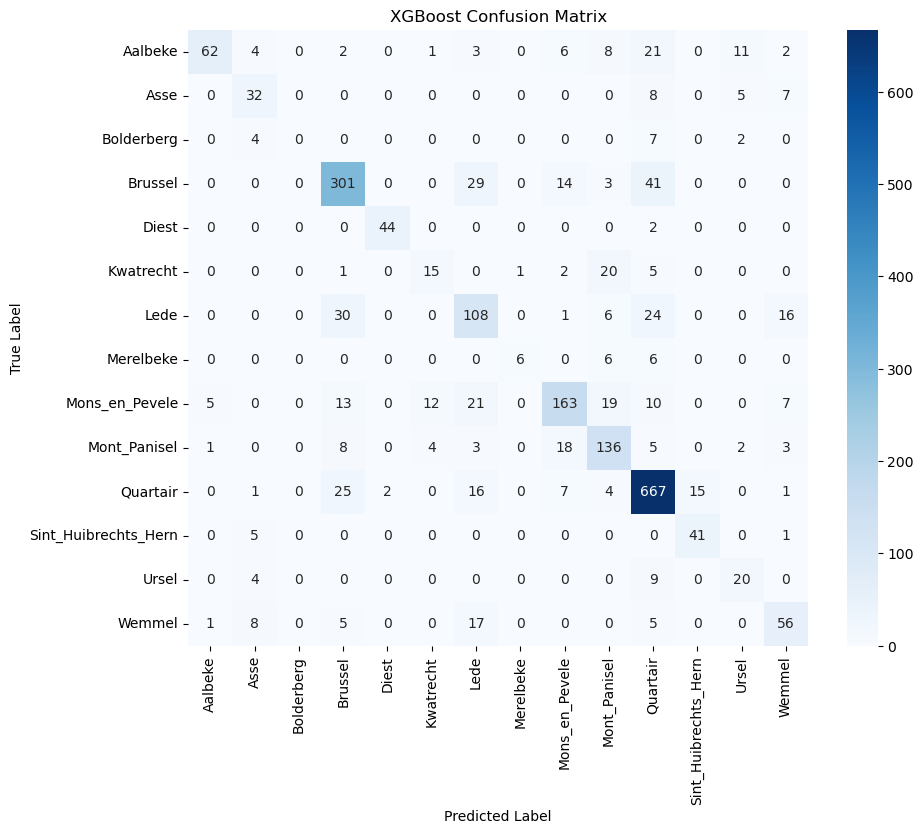

In [10]:
# XGBoost Evaluation
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_xgb, le.classes_, title="XGBoost Confusion Matrix")

In [11]:
# Random Forest Training
print("Training Random Forest...")
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", n_jobs=1))
])

rf_params = {
    "classifier__n_estimators": [100, 300],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_split": [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=rf_params,
    n_iter=5, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)

rf_search.fit(X_train, y_train_enc)
best_rf = rf_search.best_estimator_

print(f"Best RF Params: {rf_search.best_params_}")
print(f"Best CV Accuracy: {rf_search.best_score_:.4f}")

Training Random Forest...
Best RF Params: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__max_features': 'log2'}
Best CV Accuracy: 0.5473
Best RF Params: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__max_features': 'log2'}
Best CV Accuracy: 0.5473


Random Forest Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.85      0.51      0.64       120
                Asse       0.55      0.71      0.62        52
          Bolderberg       0.00      0.00      0.00        13
             Brussel       0.77      0.85      0.81       388
               Diest       0.94      0.96      0.95        46
           Kwatrecht       0.44      0.32      0.37        44
                Lede       0.62      0.57      0.60       185
           Merelbeke       0.89      0.44      0.59        18
      Mons_en_Pevele       0.75      0.67      0.70       250
        Mont_Panisel       0.67      0.76      0.71       180
            Quartair       0.85      0.89      0.87       738
Sint_Huibrechts_Hern       0.79      0.98      0.88        47
               Ursel       0.57      0.70      0.63        33
              Wemmel       0.72      0.66      0.69        92

            accuracy           

/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


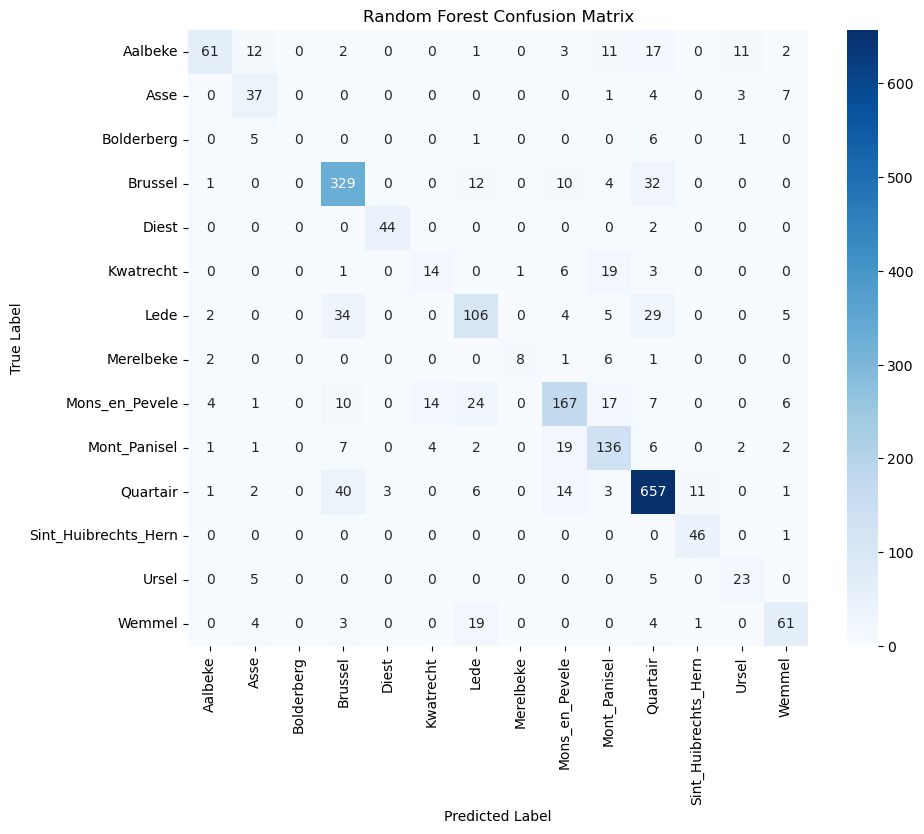

In [12]:
# Random Forest Evaluation
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_rf, le.classes_, title="Random Forest Confusion Matrix")

In [13]:
# LightGBM Training
print("Training LightGBM...")
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(verbose=-1, n_jobs=1))
])

lgbm_params = {
    "classifier__n_estimators": [100, 300],
    "classifier__num_leaves": [31, 63],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__feature_fraction": [0.7, 0.9]
}

lgbm_search = RandomizedSearchCV(
    lgbm_pipeline, 
    param_distributions=lgbm_params,
    n_iter=5, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED
)

lgbm_search.fit(X_train, y_train_enc)
best_lgbm = lgbm_search.best_estimator_

print(f"Best LGBM Params: {lgbm_search.best_params_}")
print(f"Best CV Accuracy: {lgbm_search.best_score_:.4f}")

Training LightGBM...


/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warni

Best LGBM Params: {'classifier__num_leaves': 63, 'classifier__n_estimators': 100, 'classifier__learning_rate': 0.1, 'classifier__feature_fraction': 0.7}
Best CV Accuracy: 0.5268


/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.84      0.52      0.64       120
                Asse       0.52      0.54      0.53        52
          Bolderberg       0.00      0.00      0.00        13
             Brussel       0.82      0.82      0.82       388
               Diest       1.00      0.89      0.94        46
           Kwatrecht       0.48      0.32      0.38        44
                Lede       0.59      0.63      0.61       185
           Merelbeke       0.80      0.22      0.35        18
      Mons_en_Pevele       0.82      0.70      0.76       250
        Mont_Panisel       0.68      0.78      0.73       180
            Quartair       0.83      0.91      0.87       738
Sint_Huibrechts_Hern       0.74      0.91      0.82        47
               Ursel       0.44      0.55      0.49        33
              Wemmel       0.67      0.66      0.67        92

            accuracy                

/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


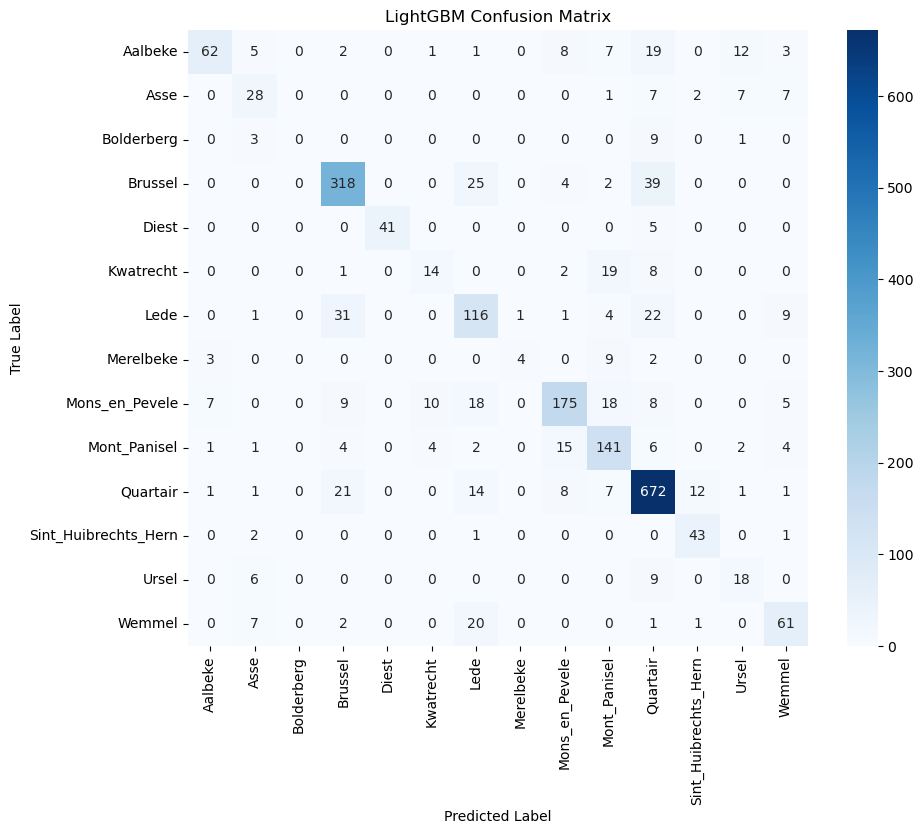

In [14]:
# LightGBM Evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test_enc, y_pred_lgbm, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_lgbm, le.classes_, title="LightGBM Confusion Matrix")

In [15]:
# Model Comparison & Export
results = {
    "xgb": {"model": best_xgb, "pred": y_pred_xgb},
    "rf": {"model": best_rf, "pred": y_pred_rf},
    "lgbm": {"model": best_lgbm, "pred": y_pred_lgbm}
}

summary = []
for name, res in results.items():
    acc = accuracy_score(y_test_enc, res["pred"])
    summary.append({"Model": name.upper(), "Test Accuracy": acc})

summary_df = pd.DataFrame(summary)
print(summary_df)

# Save Predictions
pred_folder = Path("../results/predictions_python_models")
pred_folder.mkdir(parents=True, exist_ok=True)

for name, res in results.items():
    pred_df = test_df[["sondering_id", "depth_bin", "lithostrat_id"]].copy()
    pred_df["predicted_label"] = le.inverse_transform(res["pred"])
    
    out_file = pred_folder / f"predictions_{name}_python.csv"
    pred_df.to_csv(out_file, index=False)
    print(f"Saved predictions to {out_file}")

  Model  Test Accuracy
0   XGB       0.748413
1    RF       0.765639
2  LGBM       0.767452
Saved predictions to ../results/predictions_python_models/predictions_xgb_python.csv
Saved predictions to ../results/predictions_python_models/predictions_rf_python.csv
Saved predictions to ../results/predictions_python_models/predictions_lgbm_python.csv


Preparing raw test data for full evaluation...
Raw test data shape (filtered): (64936, 20)

Confusion Matrix for XGB (Unbinned Data):

Confusion Matrix for XGB (Unbinned Data):


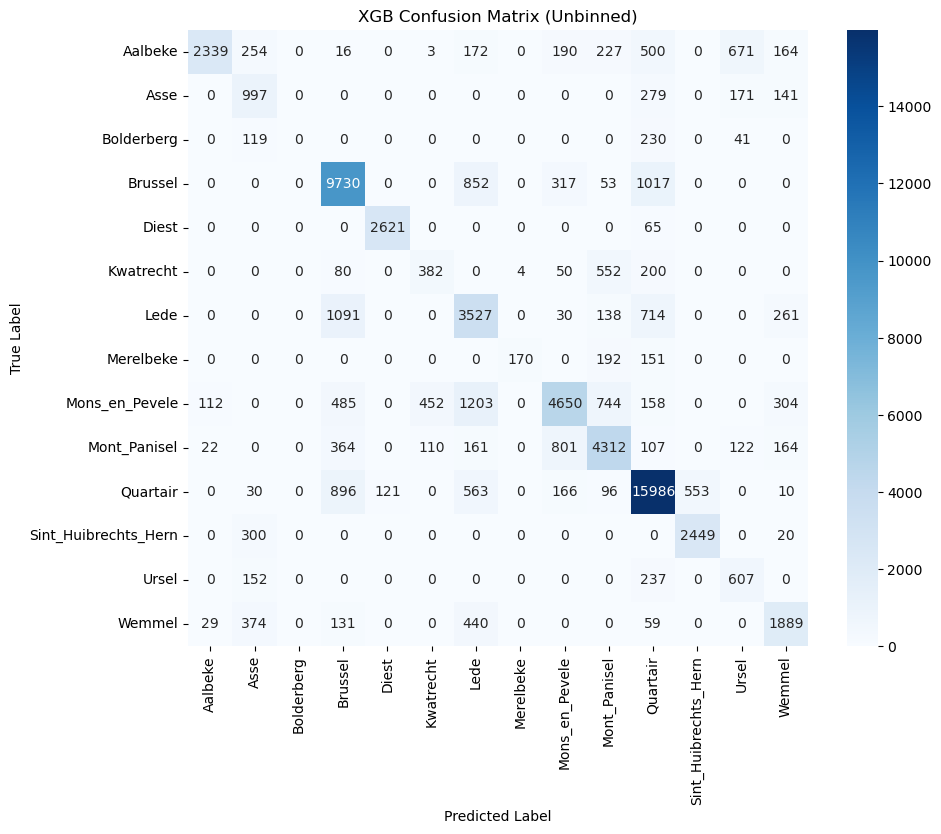


Confusion Matrix for RF (Unbinned Data):


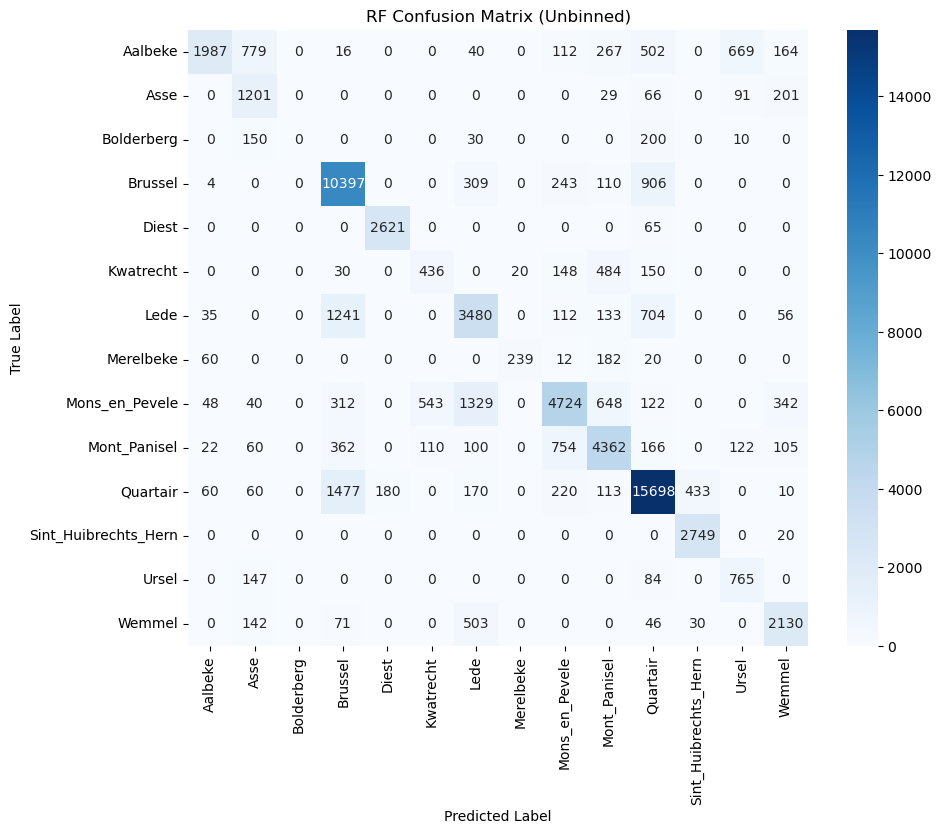


Confusion Matrix for LGBM (Unbinned Data):


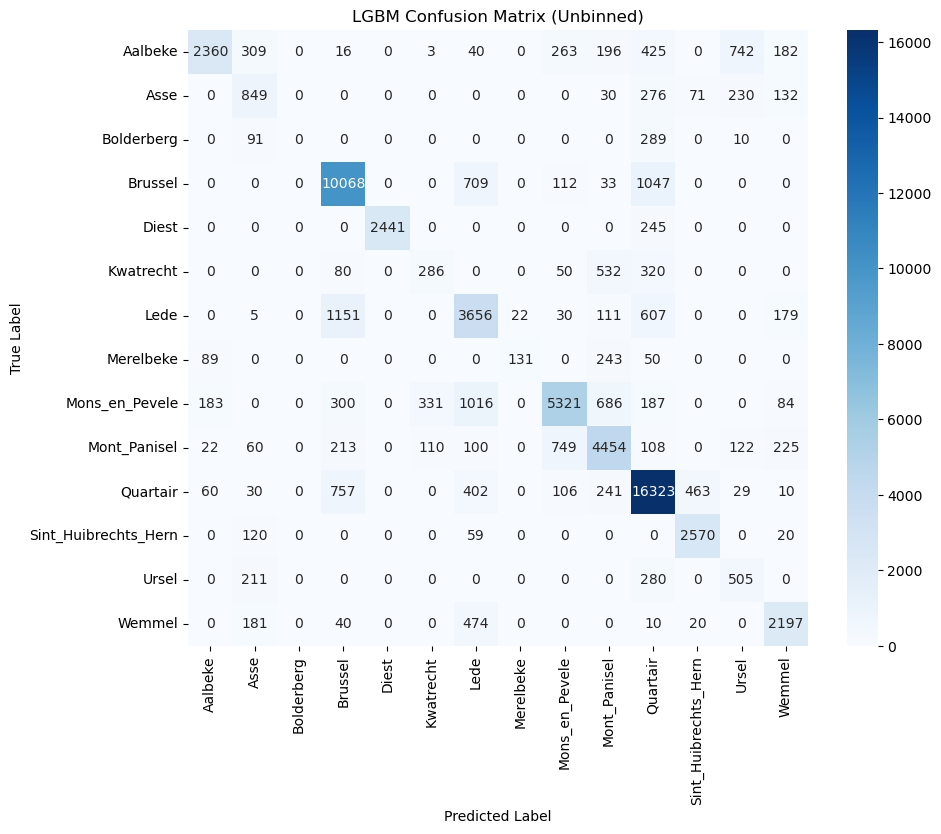


### Overall Performance on Full (Unbinned) CPT Data
  Model  Accuracy  Balanced Accuracy  F1 Score (Macro)     Kappa
0   XGB  0.729314           0.604172          0.605157  0.682208
1    RF  0.745910           0.648928          0.636924  0.702338
2  LGBM  0.751373           0.598037          0.604093  0.707476


In [17]:
# Full Dataset Evaluation (Unbinned)
from sklearn.metrics import f1_score, cohen_kappa_score, balanced_accuracy_score

print("Preparing raw test data for full evaluation...")
# 1. Get Raw Test Data
raw_test_df = cpt_data[cpt_data["sondering_id"].isin(test_ids)].copy()

# 2. Re-create Bins (Must match process_test_train logic exactly)
# process_test_train calculates bins based on the max depth of the input subset
max_depth = raw_test_df["diepte"].max()
bin_w = float(BIN_W)
bins = np.arange(0, max_depth + bin_w, bin_w)
if len(bins) < 2:
    bins = np.array([0, max_depth + bin_w])

# Apply binning
raw_test_df["depth_bin"] = pd.cut(raw_test_df["diepte"], bins=bins, include_lowest=True, ordered=True)

# 3. Filter Raw Data for Segments of Interest
# We only want to evaluate on the segments we trained on
raw_test_df = raw_test_df[raw_test_df["lithostrat_id"].isin(segments_oi) & (raw_test_df["lithostrat_id"] != "Onbekend")]

print(f"Raw test data shape (filtered): {raw_test_df.shape}")

# 4. Evaluate Each Model
full_metrics = []

for name, res in results.items():
    # Get predictions (at bin level)
    # We use test_df because that's the dataframe corresponding to the predictions
    bin_preds = test_df[["sondering_id", "depth_bin"]].copy()
    bin_preds["pred_class"] = le.inverse_transform(res["pred"])
    
    # Merge predictions onto raw data
    # Left join on raw data ensures we keep all raw measurements
    # This propagates the bin prediction to every raw measurement in that bin
    merged = pd.merge(raw_test_df, bin_preds, on=["sondering_id", "depth_bin"], how="left")
    ## write to results for debugging
    merged.to_csv(f"../results/predictions_python_models/debug_merged_{name}.csv", index=False)
    
    # Check for missing predictions
    n_missing = merged["pred_class"].isna().sum()
    if n_missing > 0:
        # This can happen if a bin exists in raw data but was filtered out of test_processed 
        # (e.g. due to missing features or NaN handling in aggregation)
        # For fair evaluation, we drop these rows as the model couldn't predict them
        merged = merged.dropna(subset=["pred_class"])
    
    # Calculate Metrics
    y_true = merged["lithostrat_id"]
    y_pred = merged["pred_class"]
    
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    kappa = cohen_kappa_score(y_true, y_pred)
    
    full_metrics.append({
        "Model": name.upper(),
        "Accuracy": acc,
        "Balanced Accuracy": bal_acc,
        "F1 Score (Macro)": f1,
        "Kappa": kappa
    })
    
    # Plot Confusion Matrix
    print(f"\nConfusion Matrix for {name.upper()} (Unbinned Data):")
    plot_confusion_matrix(y_true, y_pred, classes=le.classes_, title=f"{name.upper()} Confusion Matrix (Unbinned)")

# 5. Display Results
full_metrics_df = pd.DataFrame(full_metrics)
print("\n### Overall Performance on Full (Unbinned) CPT Data")
print(full_metrics_df)